<a href="https://colab.research.google.com/github/adrianoferruzzi/SistemaMelanoma/blob/main/MelanomaML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libs
import os
import cv2 # OpenCV
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
train_directory = '/content/drive/MyDrive/Doutorado/DSsaude/Melanoma/dataset'
test_directory = '/content/drive/MyDrive/Doutorado/DSsaude/Melanoma/test'

In [ ]:
# Listando o diretório
os.listdir(train_directory)

['0', '1']

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12204266827338616086
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14417788928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17838433670662014981
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# Carregando e redimensionando a imagem 
image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=train_directory, 
                                                      shuffle=True, target_size=(256, 256),
                                                      class_mode='categorical', subset='training')

Found 2000 images belonging to 2 classes.


In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
# segue com formato Dummy Variable
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
# benign:    0 1
# malignant: 1 0
labels_names = {0: 'benign', 1: 'malignant'}

Visualização

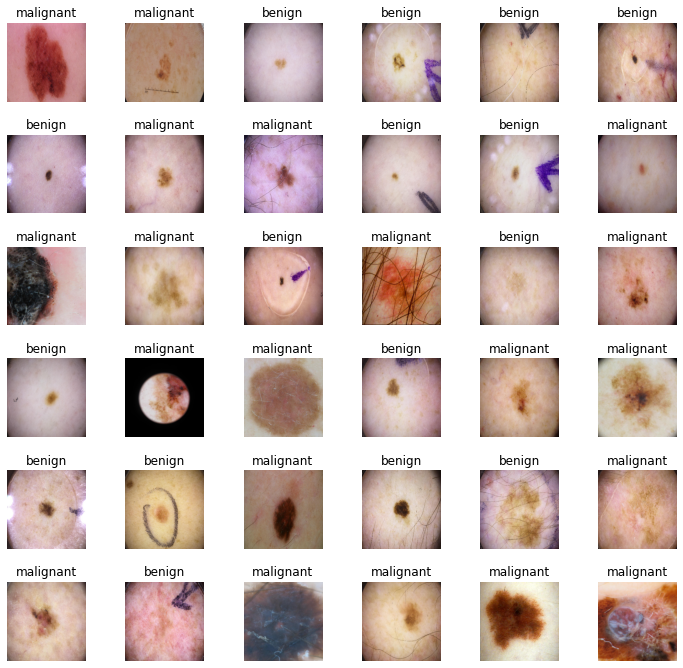

In [ ]:
# Lista as imagens em subplots de 6 linhas e 6 colunas
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
# Transforma a matriz em vetor
axes = axes.ravel()

for i in np.arange(0, 36):
 axes[i].imshow(train_images[i])
 axes[i].set_title(labels_names[np.argmax(train_labels[i])])
 axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)


Rede Neural

In [ ]:
# Carregar o modelo pré treinado e criar o dense layer
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256, 3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
len(base_model.layers)

175

In [ ]:
# Garante que as 10 útlimas camadas não serão retreinadas.
for layer in base_model.layers[:-10]:
  layers.trainable = False


Treinamento do Modelo

In [ ]:
# Criando a estrutura da rede neural

# O head_model vai começar a partir da saída do base_model
head_model = base_model.output

# Pega a média do tamanho das imagens para fazer o redimensionamento 
head_model = AveragePooling2D()(head_model)

# Flatten faz a conversão da matriz para vetor, para que seja possível fazer 
# o input dos pixels na rede neural
# Dessa forma é criada a camada de entrada da rede neural
head_model = Flatten()(head_model)

# Criando a camada de rede neural oculta 
# Activation relu é usada como padrão para redes neurais
# ReLU (ReLU é a unidade linear rectificada) é a função de ativação mais amplamente utilizada ao projetar redes neurais atualmente.
# Primeiramente, a função ReLU é não linear, o que significa que podemos
# facilmente copiar os erros para trás e ter várias camadas de 
# neurônios ativados pela função ReLU.
# A principal vantagem de usar a função ReLU sobre outras funções de ativação 
# é que ela não ativa todos os neurônios ao mesmo tempo  
head_model = Dense(256, activation='relu')(head_model)

# Dropout faz o algoritmo zerar 20% do modelo para evitar overffiting
head_model = Dropout(0.2)(head_model)

# Criando a segunda camada de rede neural oculta 
head_model = Dense(256, activation='relu')(head_model)

# Dropout faz o algoritmo zerar 20% do modelo para evitar overffiting
head_model = Dropout(0.2)(head_model)

# Criando a camada de saída com 2 neurônios para classificar as 2 classes
# Estou usando o sigmoid porque temos uma classificação com 2 saídas. 
# Caso fosse necessário classificar mais de duas saídas usariamos 'softmax',
# pois ele gera um valor de probabilidade para cada uma das classes.
head_model = Dense(2, activation='softmax')(head_model)


In [ ]:
# Criando o modelo de rede neural
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
# Compilando o modelo
# A função de erro é o categorical_crossentropy que funções de logaritmo que torna a execução mais rápida
# Ajuste dos pesos optimizer=optimizers.RMSprop
# Avaliação do algoritmo metrics = ['accuracy']
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Salvando o modelo 
# Se houver uma base de dados de validação, pode-se salvar o melhor modelo com o parâmetro save_best_only=True
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Doutorado/DSsaude/Melanoma/weights.hdf5')

In [ ]:
# Redefinindo o train_generator para batch_size = 4
# Significa que ele calculará os pesos de 4 em 4 imagens
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=train_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 2000 images belonging to 2 classes.


In [ ]:
# Faz o treinamento fit e salva na variável history
# Sem GPU levou quase a noite toda
# Com GPU levou por volta de 50 minutos
# epochs - Define quantas vezes serão feitos os ajustes dos pesos
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

<ipython-input-126-96578dcddfa4>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs = 25,


Epoch 1/25
500/500 [==============================] - 195s 370ms/step - loss: 0.6869 - accuracy: 0.7570
Epoch 2/25
500/500 [==============================] - 181s 362ms/step - loss: 0.4982 - accuracy: 0.8120
Epoch 3/25
500/500 [==============================] - 183s 366ms/step - loss: 0.4523 - accuracy: 0.8330
Epoch 4/25
500/500 [==============================] - 181s 363ms/step - loss: 0.4078 - accuracy: 0.8460
Epoch 5/25
500/500 [==============================] - 180s 360ms/step - loss: 0.3429 - accuracy: 0.8835
Epoch 6/25
500/500 [==============================] - 180s 361ms/step - loss: 0.2743 - accuracy: 0.9060
Epoch 7/25
500/500 [==============================] - 179s 357ms/step - loss: 0.2423 - accuracy: 0.9325
Epoch 8/25
500/500 [==============================] - 180s 360ms/step - loss: 0.1914 - accuracy: 0.9495
Epoch 9/25
500/500 [==============================] - 180s 360ms/step - loss: 0.1490 - accuracy: 0.9585
Epoch 10/25
500/500 [==============================] - 180s 361m

Avaliação da Rede Neural

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

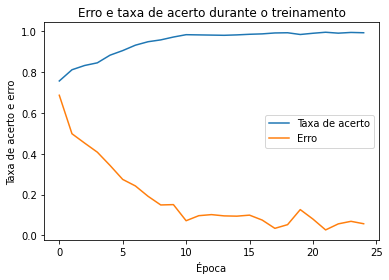

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [ ]:
# Fazendo o teste do modelo treinado 
# O diretório de teste já está carregado no início

In [ ]:
# Lista os diretórios carregados
os.listdir(test_directory)

['0', '1']

In [ ]:
# Fazendo o redimensionamento das imagens
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 400 images belonging to 2 classes.


In [ ]:
# Fazendo a avaliação com o tensorflow
evaluate = model.evaluate_generator(test_generator)

<ipython-input-156-25d2b31fd7e3>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator)


In [ ]:
evaluate

[3.599196195602417, 0.9100000262260437]

In [ ]:
len(os.listdir(test_directory))

2

In [ ]:
# Armazenando as previsões de teste
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    # print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 21ms/step


In [ ]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 

In [ ]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(original, prediction)

0.7175

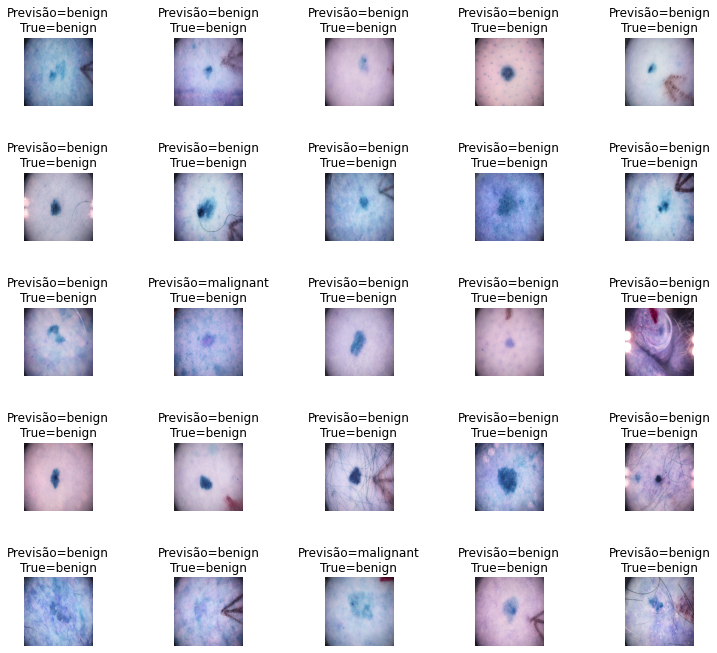

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))

# Transforma de matriz para vetor
axes = axes.ravel()

for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [ ]:
labels_names

{0: 'benign', 1: 'malignant'}

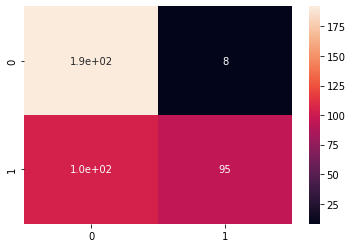

In [ ]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.65      0.96      0.77       200
           1       0.92      0.47      0.63       200

    accuracy                           0.72       400
   macro avg       0.78      0.72      0.70       400
weighted avg       0.78      0.72      0.70       400



# Classificando uma única imagem do Google Drive
Neste exemplo de aplicação, utiliza-se a importação de uma imagem a partir o Google Drive.

Foi utilizada uma imagem do diretório "test"

**OBSERVAÇÂO:** Este é só um app de testes para o aprendizado de redes neurais. Caso apareça alguma mancha em seu corpo, procure um médico!

In [ ]:
# Carregando o modelo treinado
from keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/Doutorado/DSsaude/Melanoma/weights.hdf5')

In [ ]:
model_loaded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Doutorado/DSsaude/Melanoma/test/1/ISIC_4799999.JPG')

In [ ]:
img, img.shape

(array([[[32, 31, 41],
         [31, 30, 40],
         [30, 29, 39],
         ...,
         [19, 18, 28],
         [23, 22, 32],
         [27, 26, 36]],
 
        [[34, 33, 43],
         [33, 32, 42],
         [32, 31, 41],
         ...,
         [23, 22, 32],
         [26, 25, 35],
         [30, 29, 39]],
 
        [[32, 31, 41],
         [31, 30, 40],
         [31, 30, 40],
         ...,
         [25, 24, 34],
         [28, 27, 37],
         [30, 29, 39]],
 
        ...,
 
        [[20, 18, 24],
         [20, 18, 24],
         [21, 19, 25],
         ...,
         [46, 59, 85],
         [46, 61, 87],
         [45, 60, 86]],
 
        [[22, 20, 26],
         [22, 20, 26],
         [22, 20, 26],
         ...,
         [45, 58, 84],
         [46, 61, 87],
         [45, 60, 86]],
 
        [[26, 24, 30],
         [25, 23, 29],
         [25, 23, 29],
         ...,
         [44, 57, 83],
         [44, 59, 85],
         [43, 58, 84]]], dtype=uint8), (2448, 3264, 3))

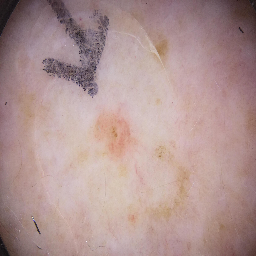

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

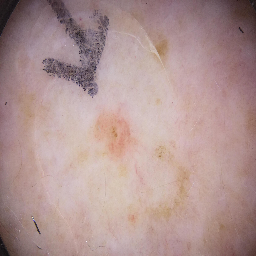

In [ ]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [ ]:
# Fazendo a normalização da escala dos valores
img = img / 255
img

array([[[0.10980392, 0.10588235, 0.14509804],
        [0.10588235, 0.10196078, 0.14509804],
        [0.12156863, 0.10980392, 0.15686275],
        ...,
        [0.10588235, 0.10980392, 0.13333333],
        [0.09411765, 0.08627451, 0.13333333],
        [0.09411765, 0.09019608, 0.12941176]],

       [[0.11372549, 0.10980392, 0.14901961],
        [0.08627451, 0.07843137, 0.1254902 ],
        [0.11764706, 0.10588235, 0.15294118],
        ...,
        [0.1372549 , 0.14117647, 0.16470588],
        [0.10196078, 0.09411765, 0.14117647],
        [0.13333333, 0.1254902 , 0.16862745]],

       [[0.1254902 , 0.10980392, 0.15294118],
        [0.10196078, 0.08627451, 0.12941176],
        [0.12941176, 0.11372549, 0.15686275],
        ...,
        [0.15686275, 0.14901961, 0.19215686],
        [0.11764706, 0.11372549, 0.15294118],
        [0.10196078, 0.10588235, 0.14509804]],

       ...,

       [[0.09411765, 0.08627451, 0.10980392],
        [0.10196078, 0.09411765, 0.11764706],
        [0.09411765, 0

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [ ]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.2959039e-06, 9.9999774e-01]], dtype=float32)>

In [ ]:
predict2 = np.argmax(predict)
predict2

1

In [ ]:
labels_names[predict2], predict[0][predict2]

('malignant', <tf.Tensor: shape=(), dtype=float32, numpy=0.99999774>)